# Snake Charge Scan

To manipulate an electron confined by gate-defined quantum dot, it is essential to control the number of electron i.e. the chemical potential of each quantum dot and the tunnel coupling among quantum dots. The charge stability diagram (CSD) represents electrostatic characteristics of such a quantum dot system for a give charge configuration which suggests the operation point and the work window for further experiements. However, the CSD depends on the sweep direction of gate voltages thus a charge state hysteresis in quantum dots has been observed and inverstigated. [1]

[1] C. H. Yang, et al., Appl. Phys. Lett. 105, 183505 (2014)

In this tutorial, a pulse for the bi-directional sweep of a CSD is constructed so that the hysteresis of charge occupancy in a double quantum dot system can be measured. For ease of analysis, 2 different measurement windows namingly `('x_neg', 'x_pos')` are defined providing the possibliy of inspecting two sweep direction individually. Options of `plot` function in `qupulse.pulses.plotting` will be explored as well.

TODO: add some figures here...

## Task 1: Piece-wised voltage level

 ### Description:
 Let 2 AWG channels `(X, Y)` hold at a given set of voltages `(x_start, y_start)` for specific time durations `t_hold`.  

 ### Goal:  
 making a pulse without thinking the time consumption or the memory consumption.
 
 Firtly, we build a piece of voltage level with free parameters `t_hold` and `sample_rate` representing the time duration of such voltage level and the sample rate of AWG, respectively. With aforementioned parameters, a universal piece-wised pulse can be used as a building block of most experiments with flexibility of adjusting the pulse duration and hardward settings i.e. the sample rate of AWG.

In [1]:
import sympy
from qupulse.pulses import ConstantPT, RepetitionPT

sample_rate, n_segments, t_hold = sympy.sympify('sample_rate, n_segments, t_hold')
t_segment = n_segments / sample_rate

segment = ConstantPT(t_segment, {'X': 'x_start + x_i * x_step', 
                                 'Y': 'y_start + y_i * y_step'}
                    )
body = RepetitionPT(segment, t_hold // t_segment, measurements=[('M', 0, 't_hold')])

Now that a piece of voltage level is constructed with given voltages

A charge stability diagram can be abstracted by 2 nested for loop using `ForLoopPT` in qupulse. In order to define the name of measurement window for different sweep direction, the `ForLoopPT` is wrapped by a `MappingPT`.

The voltage resolution of the scan is described by `{x_step, y_step}` which are converted by qupulse according to the user inputs `{x_start, x_stop, N_x, y_start, y_stop, N_y}` representing the start voltage and stop voltages on different scan axis and the number of voltage levels of each axes.

In [5]:
from qupulse.pulses import MappingPT, ForLoopPT
inner_loop_fwd = MappingPT(ForLoopPT(body, 'x_i', 'N_x'), measurement_mapping={'M': 'x_pos'})
inner_loop_bwd = MappingPT(ForLoopPT(body, 'x_i', ('N_x - 1', -1, -1)), measurement_mapping={'M': 'x_neg'})

# concatinate two pulse templates by '@'
inner_loop = inner_loop_fwd @ inner_loop_bwd
outer_loop = ForLoopPT(inner_loop, 'y_i', 'N_y')

# here we make a linear interpolation of sweep axes.
snake_sweep_seg = MappingPT(outer_loop, parameter_mapping={'x_step': '(x_stop - x_start) / (N_x - 1)',
                                                           'y_step': '(y_stop - y_start) / (N_y - 1)'})

In [6]:

snake_cds = MappingPT(snake_sweep_seg,
                      parameter_mapping={'t_hold': 'cds_res'},
                      identifier='Snake_CDS')
print(snake_cds.parameter_names)

{'cds_res', 'y_stop', 'x_stop', 'x_start', 'N_x', 'y_start', 'sample_rate', 'N_y', 'n_segments'}


Let's generate a pulse for a bi-directional charge scan with voltage resolution 0.3V/point on x-axis and 0.4V/point on y-axis. The time resolution `cds_res` here is arbitarily chosen for demonstration.

In [35]:
default_params = {
    'n_segments': 2,
    'x_start': 0,
    'x_stop': 3,
    'y_start': 0,
    'y_stop': 2,
    'N_x': 10,
    'N_y': 5,
    'sample_rate': 1,
    'cds_res': 5
}

Now, we use `plot` function to inspect the positive sweep of channel X which is highlighted in the following plot.

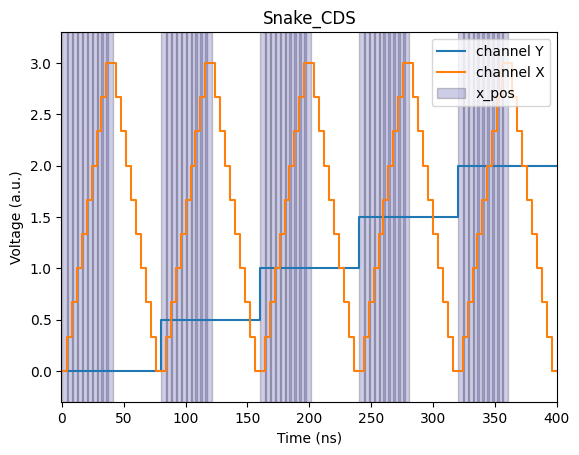

In [15]:
from qupulse.pulses.plotting import plot

_=plot(snake_cds, parameters=default_params, sample_rate=1, plot_measurements='x_pos')

Similaly the negative sweep is inspected by assigning the measurement window name `x_neg` to the input argument `plot_measurement` of `plot` function provided by qupulse.

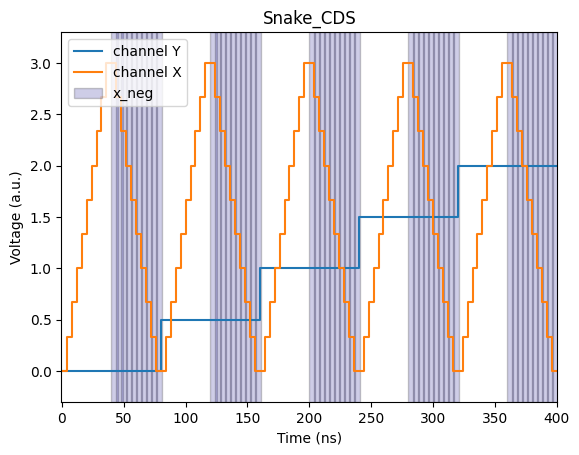

In [16]:
_=plot(snake_cds, parameters=default_params, sample_rate=1, plot_measurements='x_neg')

When we try to instantiate such a pulse it will take some time but not severe yet. However it is not a set of parameters with physical meanings. In general, a bandwidth of charge sensing falls in relatively low frequency range say slower than MHz. In addition, a voltage resolution of mV is required to resolve the charge occupancy of a quantum dot. Therefore the following parameters are used in a real experiment:

In [38]:
exp_params = {
    'n_segments': 192,          # empirically determined.
    'x_start': -50e-3,
    'x_stop': 50e-3,
    'y_start': 0,
    'y_stop': 0.1,              
    'N_x': 100,                 # voltage resolution: 1 mV
    'N_y': 100,                 # voltage resolution: 1 mV
    'sample_rate': 3.125e-3,    # AWG sample rate: 3.125 MHz
    'cds_res': 1e6              # time resolution: 1 ms
}

In [44]:
# Try with different time/voltage resolution or AWG sample rate by yourself!

import timeit
# using arbitary parameters for simplicity. 
simple_inst = timeit.timeit(lambda: snake_cds.create_program(parameters=default_params), number=1)
print(f'Elapsed time: {simple_inst} seconds')

# in a real experiment:
exp_inst = timeit.timeit(lambda: snake_cds.create_program(parameters=exp_params), number=1)
print(f'Elapsed time: {exp_inst} seconds')


Elapsed time: 0.03750840000066091 seconds
Elapsed time: 5.565738000000238 seconds


## Task 2: Simplify the pulse

With the current implementation the time consumption to instantiate pulse is unecessarily long. But which step slows down the whole process? Is there any space for improvement?  

The main concern by now is building everything in qupluse including the measurement window. Therefore the resolution of data acquisation and the pulse interpolation are not decoupled resulting in a sophisticated construction of pulse for a trivial task. In the following section, we will try to explore a way to optimize the pulse.